# Spatial Temporal prediction using GNN and LSTM

To prepare the data and code an NN model for spatio temporal task would be challegnging. Here we can use a package called `torch-geometric-temporal` to ease the process: https://github.com/benedekrozemberczki/pytorch_geometric_temporal

It is still quite complicated. Another merit of `torch-geometric-temporal` is that the developers coded many known model structures from research papers.

In [1]:
#pip install torch-geometric-temporal

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GraphConv,Linear
from torch_geometric_temporal.nn.recurrent import GConvLSTM
from torch_geometric_temporal.signal.static_graph_temporal_signal import StaticGraphTemporalSignal
from torch_geometric_temporal.signal import temporal_signal_split

Here we use the air pollution example data. 

In [4]:
air = pd.read_csv("https://raw.githubusercontent.com/Ziqi-Li/GIS5122/main/data/pollution_data.csv",
                  date_format=True)

air.ffill(inplace=True)#replace missing values by

### Data preprocessing

Here we get the unique cities to generate the Graph network with each city as a node.

In [5]:
stations = air[['City','latitude', 'longitude']].drop_duplicates()

For simplicity, we remove cities with missing daily observations, to only keep the city with 668 records.

In [6]:
incomp_cities = []
for station in stations.City:
    city_air = air.loc[air.City == station,]
    
    if city_air.shape[0] < 668:
        incomp_cities.append(station)

This will give us 27 cities at the end.

In [7]:
air = air[~air['City'].isin(incomp_cities)].reset_index()
stations = air[['City','latitude', 'longitude']].drop_duplicates()
stations.shape

(27, 3)

Next we use the cities to generate the graph, here we use the distance between lat and long coordinates to get a distance. 

Note: Here, technically, we should project the map data and calculate the projected distance (e.g., in meters) rather than the angular distance (e.g., in degees/radians).

Since we only have 27 stations, the graph is small, so we can keep all the edges between pairs of nodes. So we can set a very large `threshold_distance`.

In [8]:
%%time

from scipy.spatial import distance

# Get the number of properties as nodes
num_nodes = stations.shape[0]

edges = []


coordinates = stations[['latitude', 'longitude']].values

threshold_distance = 100 #degrees

#Loop over all the pairs of nodes/locations
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        
        #Calculate distance between two nodes in the unit of mile
        dist = distance.euclidean(coordinates[i], coordinates[j])
        
        #Add an edge if the distance is below the threshold_distance
        if dist < threshold_distance:
            
            edges.append((i, j))
            edges.append((j, i))
            

#Make it a tensor
edges = torch.tensor(edges, dtype=torch.long).t().contiguous()

CPU times: user 2.35 ms, sys: 2.38 ms, total: 4.73 ms
Wall time: 3.1 ms


We end up with this shape for the edges

In [9]:
edges.shape

torch.Size([2, 702])

Next we calculate the weights based on a gaussian kernel.

In [10]:
def compute_edge_distances(x, edge_index):
    # Extract node features for each edge
    node_features_start = x[edge_index[0]]
    node_features_end = x[edge_index[1]]

    # Compute Euclidean distance between nodes for each edge
    distances = torch.sqrt(torch.sum((node_features_start - node_features_end) ** 2, dim=1))
    return distances

def distance_to_weight(distances, sigma=50):
    # Convert distances to weights using a Gaussian kernel
    weights = torch.exp(- (distances ** 2) / (2 * sigma ** 2))
    return weights

In [11]:
distances = compute_edge_distances(torch.tensor(coordinates), edges)
weights =  distance_to_weight(distances)

In [12]:
weights.shape

torch.Size([702])

We process the time-series data and to generate historical sequences.

In [13]:
from sklearn.preprocessing import MinMaxScaler

def create_sequences(data, n_past_steps):
        X, y = [], []
        for i in range(n_past_steps, len(data)):
            X.append(data[i-n_past_steps:i, :])
            y.append(data[i, 0]) 
        return np.array(X), np.array(y)

X, y = [], []


n_past_steps = 3  # Number of past timesteps you want to use for prediction

for station in stations.City:
    city_air = air.loc[air.City == station,]
    
    features = city_air[['temperature_median','temperature_median']].values

    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(features)

    
    city_X, city_y = create_sequences(scaled_data, n_past_steps)
    
    X.append(city_X)
    y.append(city_y)

The dimension of your features should be (T, N, PT) where T is the number of timestamps, N is the number of nodes, and PT is the number of past timesteps you want to use for prediction.

So a transpose is needed here.

In [14]:
np.array(X).shape

(27, 665, 3, 2)

In [15]:
X_raw = np.transpose(np.array(X),axes=[3,1,0,2])
X_ready = X_raw[0]

In [16]:
X_ready.shape

(665, 27, 3)

The dimension of your labels should be (T, N) where T is the number of timestamps and N is the number of nodes.

In [17]:
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_ready = y_scaler.fit_transform(np.array(y).T)

### Final data prepration to be ready for modelling

In [18]:
air_dataset = StaticGraphTemporalSignal(edge_index = edges.numpy(), 
                                        edge_weight = weights.numpy(), 
                                        features=X_ready, targets=y_ready)

Train/Test split

In [19]:
train_dataset, test_dataset = temporal_signal_split(air_dataset, train_ratio=0.8)

### Define our model

The model will involve a GNN-LSTM layer and then two fully connected layers.

Feel free to experiment with different sizes of your NN.

In [20]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features):
        super(RecurrentGCN, self).__init__()
        
        self.recurrent = GConvLSTM(node_features, 32, 1)
        
        # Two fully-connected layers
        self.fc1 = Linear(32, 16)
        self.fc2 = Linear(16, 8)
        
        self.linear = Linear(8, 1)


    def forward(self, x, edge_index, edge_weight, h, c):
        h_0, c_0 = self.recurrent(x, edge_index, edge_weight, h, c)
        
        h = F.relu(h_0)
        
        h = self.fc1(h)
        h = F.relu(h)
        
        h = self.fc2(h)
        h = F.relu(h)
        
        h = self.linear(h)
        
        return h, h_0, c_0

In [21]:
model = RecurrentGCN(node_features=n_past_steps)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

RecurrentGCN(
  (recurrent): GConvLSTM(
    (conv_x_i): ChebConv(3, 32, K=1, normalization=sym)
    (conv_h_i): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_f): ChebConv(3, 32, K=1, normalization=sym)
    (conv_h_f): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_c): ChebConv(3, 32, K=1, normalization=sym)
    (conv_h_c): ChebConv(32, 32, K=1, normalization=sym)
    (conv_x_o): ChebConv(3, 32, K=1, normalization=sym)
    (conv_h_o): ChebConv(32, 32, K=1, normalization=sym)
  )
  (fc1): Linear(32, 16, bias=True)
  (fc2): Linear(16, 8, bias=True)
  (linear): Linear(8, 1, bias=True)
)

In [22]:
%%time

train_losses = []
val_losses = []


#tqdm here is to enable a progress bar for your loop
for epoch in tqdm(range(1000)):
    loss = 0
    y_pred_train = []
    y_pred_test = []
    h, c = None, None
    for time, snapshot in enumerate(train_dataset):
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        
        loss = loss + torch.mean((y_hat-snapshot.y)**2)
        
        y_pred_train.append(y_hat.detach().numpy())
    
    loss = loss / (time+1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    train_losses.append(loss.item())
    
    model.eval()
    loss = 0
    for time, snapshot in enumerate(test_dataset):
        
        y_hat, h, c = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr, h, c)
        loss = loss + torch.mean((y_hat-snapshot.y)**2)
        
        y_pred_test.append(y_hat.detach().numpy())
        
    loss = loss / (time+1)
    val_losses.append(loss.item())


100%|███████████████████████████████████████| 1000/1000 [11:58<00:00,  1.39it/s]

CPU times: user 11min 45s, sys: 5.34 s, total: 11min 51s
Wall time: 11min 58s


In [23]:
np.array(y_pred_train).shape

(532, 27, 1)

In [24]:
np.array(y_pred_test).shape

(133, 27, 1)

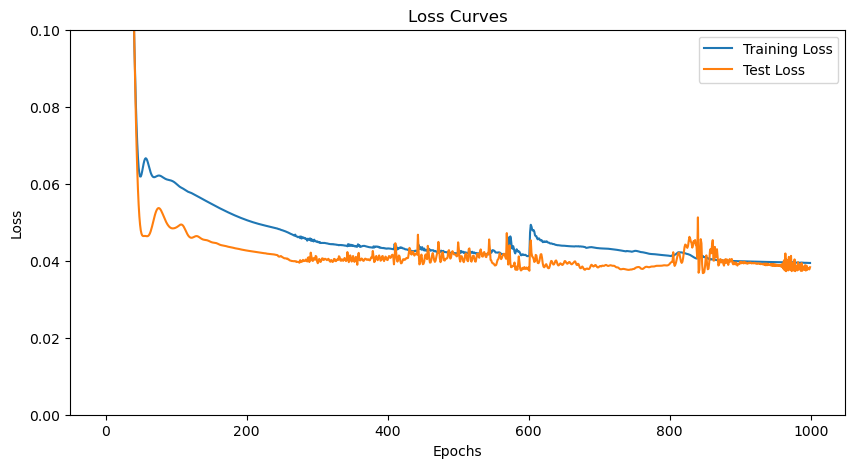

In [25]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Test Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.ylim(0,0.1)
plt.legend()
plt.show()

In [45]:
predy = np.vstack([np.array(y_pred_train),np.array(y_pred_test)])[:,:,0]

In [46]:
y_ready.shape

(665, 27)

We can examine the modeled time-series for different cities

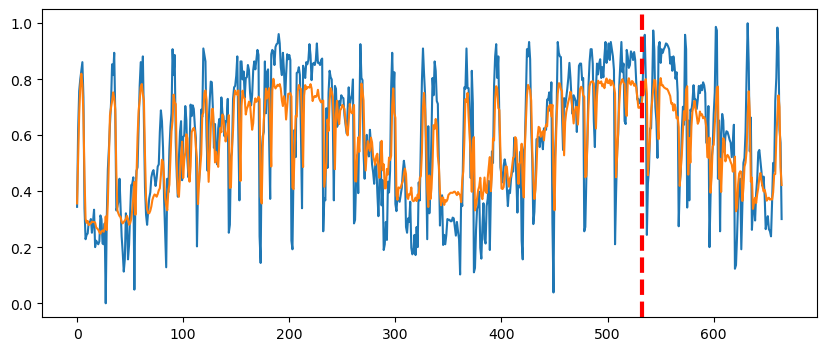

In [50]:
city_id = 0

plt.figure(figsize=(10,4))
plt.plot(y_scaler.inverse_transform(y_ready)[:,city_id])
plt.plot(y_scaler.inverse_transform(predy)[:,city_id])
plt.axvline(x = 532, color ='red',ls='--', lw=3)